Import Data

In [11]:
pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
    --------------------------------------- 0.5/39.5 MB 5.6 MB/s eta 0:00:07
   - -------------------------------------- 1.8/39.5 MB 5.6 MB/s eta 0:00:07
   --- ------------------------------------ 3.1/39.5 MB 5.6 MB/s eta 0:00:07
   ---- ----------------------------------- 4.5/39.5 MB 5.8 MB/s eta 0:00:07
   ----- ---------------------------------- 5.5/39.5 MB 5.6 MB/s eta 0:00:07
   ------ --------------------------------- 6.3/39.5 MB 5.2 MB/s eta 0:00:07
   ------ --------------------------------- 6.8/39.5 MB 5.1 MB/s eta 0:00:07
   ------- -------------------------------- 7.3/39.5 MB 4.7 MB/s eta 0:00:07
   -------- ------------------------------- 8.4/39.5 MB 4.5 MB/s eta 0:00:07
   --------- ------------------------------ 9.4/39.5 MB 4.6 MB/s eta 0:00:07
   ---------- ----------------------------- 10.7/39.5 MB 4.8 MB/s eta 0:00:07
   ------------ --------------------------- 12.3/39.5 MB 4.9 MB/s eta 0:00:06
   -


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
path = r'D:\NOTEBOOK\FYP\KaggleDataset\craters'

train_img_path = os.path.join(path, 'train', 'images')
train_lbl_path = os.path.join(path, 'train', 'labels')
valid_img_path = os.path.join(path, 'valid', 'images')
valid_lbl_path = os.path.join(path, 'valid', 'labels')
test_img_path = os.path.join(path, 'test', 'images')
test_lbl_path = os.path.join(path, 'test', 'labels')

In [4]:
# EDA and Data Preprocessing
# labels .txt trans to Pandas DataFrame
def load_labels(label_path):
    label_files = os.listdir(label_path)
    data = []
    classes = set()
    for file in label_files:
        with open(os.path.join(label_path, file), 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = list(map(float, line.strip().split()))
                data.append([file, *parts])
                classes.add(int(parts[0]))
    df = pd.DataFrame(data, columns=['file', 'class', 'x_center', 'y_center', 'width', 'height'])
    return df, sorted(classes)

train_labels, train_classes = load_labels(train_lbl_path)
valid_labels, valid_classes = load_labels(valid_lbl_path)
test_labels, test_classes = load_labels(test_lbl_path)

In [5]:
# Get all unique classes
all_classes = sorted(set(train_classes + valid_classes + test_classes))
class_names = [f'class_{i}' for i in all_classes]

In [6]:
# Display first few rows of the labels
print("Train Labels")
print(train_labels.head())
print("\nValidation Labels")
print(valid_labels.head())
print("\nTest Labels")
print(test_labels.head())

Train Labels
                                              file  class  x_center  y_center  \
0  011_png.rf.8ac312b4898f0106d10b76952a55d237.txt    0.0  0.449219  0.076563   
1  011_png.rf.8ac312b4898f0106d10b76952a55d237.txt    0.0  0.323437  0.866406   
2  011_png.rf.8ac312b4898f0106d10b76952a55d237.txt    0.0  0.112500  0.877344   
3  011_png.rf.8ac312b4898f0106d10b76952a55d237.txt    0.0  0.752344  0.917188   
4  011_png.rf.8ac312b4898f0106d10b76952a55d237.txt    0.0  0.618750  0.135156   

      width    height  
0  0.085938  0.096094  
1  0.184375  0.177344  
2  0.215625  0.220312  
3  0.089844  0.100781  
4  0.119531  0.126562  

Validation Labels
                                              file  class  x_center  y_center  \
0  014_png.rf.6b86c8afeb3ebca92872fd966d076adc.txt    0.0  0.781250  0.070312   
1  014_png.rf.6b86c8afeb3ebca92872fd966d076adc.txt    0.0  0.099219  0.070312   
2  014_png.rf.6b86c8afeb3ebca92872fd966d076adc.txt    0.0  0.553125  0.703125   
3  014_png.rf

In [8]:
# Create data.yaml to specify the data path and category information
data_yaml_content = f"""
train: {train_img_path}
val: {valid_img_path}
test: {test_img_path}

nc: {len(all_classes)}  # number of classes
names: {class_names}  # class names
"""
# WR data.yaml
data_yaml_path = os.path.join(path, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content)

In [15]:
# Image Preprocessing and Visualization

# Function to visualize sample images with bounding boxes
def visualize_sample_images(image_path, label_df, n_samples=5):
    # Get the first `n_samples` image filenames from the directory
    image_files = os.listdir(image_path)[:n_samples]
    for img_file in image_files:
        img_path = os.path.join(image_path, img_file)
        # Read and convert the image from BGR to RGB (OpenCV loads images in BGR format)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Create a figure for visualization
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(img)
        # Get labels corresponding to the current image file
        labels = label_df[label_df['file'] == img_file]
        for _, label in labels.iterrows():
            x_center = int(label['x_center'] * img.shape[1])
            y_center = int(label['y_center'] * img.shape[0])
            width = int(label['width'] * img.shape[1])
            height = int(label['height'] * img.shape[0])
            # Calculate top-left corner of the bounding box
            x_min = x_center - width // 2
            y_min = y_center - height // 2
            # Draw the bounding box on the image
            rect = plt.Rectangle((x_min, y_min), width, height, edgecolor='red', facecolor='none', linewidth=2)
            ax.add_patch(rect)
        # Set title and remove axis for better visualization
        plt.title(f'Sample Image: {img_file}')
        plt.axis('off')
        plt.show()

# visualize_sample_images(train_img_path, train_labels)
# visualize_sample_images(valid_img_path, valid_labels)
# visualize_sample_images(test_img_path, test_labels)

YOLO V8


In [16]:
!pip install -q ultralytics
from ultralytics import YOLO


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\lenovo\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [17]:
model = YOLO('yolov8n.pt')
# Train
model.train(data=data_yaml_path, epochs=50)
# Evaluate the model
results = model.val()
# model.save('path')

100%|██████████| 6.25M/6.25M [00:01<00:00, 6.20MB/s]


Ultralytics 8.3.78  Python-3.12.6 torch-2.6.0+cpu CPU (Intel Core(TM) i5-10210U 1.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:\NOTEBOOK\FYP\KaggleDataset\craters\data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

100%|██████████| 755k/755k [00:00<00:00, 2.92MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning D:\NOTEBOOK\FYP\KaggleDataset\craters\train\labels... 98 images, 9 backgrounds, 0 corrupt: 100%|██████████| 98/98 [00:00<00:00, 319.46it/s]

train: New cache created: D:\NOTEBOOK\FYP\KaggleDataset\craters\train\labels.cache



val: Scanning D:\NOTEBOOK\FYP\KaggleDataset\craters\valid\labels... 26 images, 2 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<00:00, 203.84it/s]

val: New cache created: D:\NOTEBOOK\FYP\KaggleDataset\craters\valid\labels.cache


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.824      3.355      1.452         40        640: 100%|██████████| 7/7 [00:41<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]

                   all         26        202     0.0162      0.624     0.0929     0.0415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.619      2.513       1.27         12        640: 100%|██████████| 7/7 [00:43<00:00,  6.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.10s/it]

                   all         26        202      0.669       0.11      0.224       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.524      1.844      1.222         31        640: 100%|██████████| 7/7 [00:38<00:00,  5.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]

                   all         26        202     0.0213      0.822      0.223      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.509      1.846      1.171         14        640: 100%|██████████| 7/7 [00:36<00:00,  5.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]

                   all         26        202      0.591      0.228      0.262      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.512      1.648      1.216         10        640: 100%|██████████| 7/7 [00:36<00:00,  5.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]

                   all         26        202          1      0.085      0.255      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.434      1.402      1.143         21        640: 100%|██████████| 7/7 [00:36<00:00,  5.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]

                   all         26        202      0.029      0.272     0.0989     0.0455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.535      1.546      1.216         15        640: 100%|██████████| 7/7 [00:37<00:00,  5.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]

                   all         26        202      0.405      0.124      0.181     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.563      1.636      1.242          6        640: 100%|██████████| 7/7 [00:36<00:00,  5.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]

                   all         26        202      0.386      0.258      0.265      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.525      1.508      1.184         14        640: 100%|██████████| 7/7 [00:37<00:00,  5.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]

                   all         26        202      0.475      0.273      0.348      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G       1.66      1.585      1.209         15        640: 100%|██████████| 7/7 [00:37<00:00,  5.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.65s/it]

                   all         26        202      0.441      0.347      0.362      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.437      1.416      1.204         19        640: 100%|██████████| 7/7 [00:37<00:00,  5.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]

                   all         26        202      0.453      0.416      0.349      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.525      1.432      1.187         33        640: 100%|██████████| 7/7 [00:37<00:00,  5.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]

                   all         26        202      0.159      0.381       0.14     0.0781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.474      1.401      1.187         20        640: 100%|██████████| 7/7 [00:40<00:00,  5.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]

                   all         26        202      0.248      0.347      0.201       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.352      1.282       1.12         16        640: 100%|██████████| 7/7 [00:36<00:00,  5.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]

                   all         26        202      0.515      0.401      0.442      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.455      1.266      1.167         37        640: 100%|██████████| 7/7 [00:36<00:00,  5.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]

                   all         26        202      0.347      0.458      0.345      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.419      1.357      1.192         33        640: 100%|██████████| 7/7 [00:37<00:00,  5.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]

                   all         26        202      0.349        0.5      0.334      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.418      1.591      1.265          3        640: 100%|██████████| 7/7 [00:37<00:00,  5.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]

                   all         26        202      0.385      0.545      0.381      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.395       1.22      1.172         20        640: 100%|██████████| 7/7 [00:37<00:00,  5.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.77s/it]

                   all         26        202      0.542      0.535      0.507      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.399      1.241      1.156          8        640: 100%|██████████| 7/7 [00:36<00:00,  5.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]

                   all         26        202      0.429       0.48      0.458      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.355      1.352       1.17         12        640: 100%|██████████| 7/7 [00:35<00:00,  5.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]

                   all         26        202      0.476      0.307       0.37      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G       1.36      1.302      1.151          6        640: 100%|██████████| 7/7 [00:36<00:00,  5.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]

                   all         26        202      0.365      0.426      0.373       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.393      1.279      1.142         17        640: 100%|██████████| 7/7 [00:37<00:00,  5.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]

                   all         26        202      0.682      0.446       0.53      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.256      1.198      1.125         26        640: 100%|██████████| 7/7 [00:36<00:00,  5.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.47s/it]

                   all         26        202      0.618      0.505      0.576      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.276      1.161      1.126         12        640: 100%|██████████| 7/7 [00:36<00:00,  5.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.50s/it]

                   all         26        202      0.569      0.614      0.607      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.297      1.144      1.128         15        640: 100%|██████████| 7/7 [00:36<00:00,  5.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]

                   all         26        202      0.726      0.614       0.67       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.363      1.084      1.154         19        640: 100%|██████████| 7/7 [00:36<00:00,  5.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]

                   all         26        202      0.752      0.579      0.669      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.352      1.155      1.119         32        640: 100%|██████████| 7/7 [00:37<00:00,  5.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]

                   all         26        202      0.657      0.619      0.667      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.302      1.108       1.09         15        640: 100%|██████████| 7/7 [00:37<00:00,  5.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]

                   all         26        202      0.657      0.619      0.669      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.262       1.07      1.092         20        640: 100%|██████████| 7/7 [00:36<00:00,  5.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]

                   all         26        202      0.638      0.614      0.658      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.226      1.031      1.098         18        640: 100%|██████████| 7/7 [00:36<00:00,  5.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]

                   all         26        202        0.7      0.594      0.663      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.309      1.241       1.18          5        640: 100%|██████████| 7/7 [00:36<00:00,  5.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.77s/it]

                   all         26        202      0.774       0.53      0.641      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.226      1.571      1.073          1        640: 100%|██████████| 7/7 [00:36<00:00,  5.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]

                   all         26        202      0.747      0.559      0.643       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.272      1.048      1.116         21        640: 100%|██████████| 7/7 [00:36<00:00,  5.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]

                   all         26        202      0.721       0.55      0.654      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.155      1.149      1.139          3        640: 100%|██████████| 7/7 [00:36<00:00,  5.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]

                   all         26        202       0.64      0.639      0.667       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.148       1.47      1.111          1        640: 100%|██████████| 7/7 [00:46<00:00,  6.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.39s/it]

                   all         26        202      0.682      0.619      0.654      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G        1.3     0.9952      1.079         27        640: 100%|██████████| 7/7 [00:52<00:00,  7.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.32s/it]

                   all         26        202       0.72      0.549      0.618      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.236     0.9932      1.079         29        640: 100%|██████████| 7/7 [00:42<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]

                   all         26        202      0.644      0.663      0.632       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.228       1.07      1.066         37        640: 100%|██████████| 7/7 [00:43<00:00,  6.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]

                   all         26        202      0.689      0.638      0.635      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.205     0.9721       1.06         30        640: 100%|██████████| 7/7 [00:43<00:00,  6.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]

                   all         26        202      0.594       0.66      0.641      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.148     0.9203      1.036         34        640: 100%|██████████| 7/7 [00:41<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]

                   all         26        202      0.632      0.604      0.646      0.372


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.305      1.148       1.13          7        640: 100%|██████████| 7/7 [00:46<00:00,  6.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]

                   all         26        202      0.715      0.569      0.646      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.288      1.112      1.076         21        640: 100%|██████████| 7/7 [00:48<00:00,  6.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]

                   all         26        202      0.612      0.629      0.619      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.148     0.9942      1.027          4        640: 100%|██████████| 7/7 [00:41<00:00,  5.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.04s/it]

                   all         26        202       0.62      0.629      0.609      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.117     0.9641      1.031          5        640: 100%|██████████| 7/7 [00:45<00:00,  6.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.58s/it]

                   all         26        202      0.622      0.653      0.628      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.184      1.022      1.062         41        640: 100%|██████████| 7/7 [00:46<00:00,  6.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.54s/it]

                   all         26        202      0.694      0.574      0.645      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.226      1.121      1.104          3        640: 100%|██████████| 7/7 [00:42<00:00,  6.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]

                   all         26        202      0.744      0.584      0.668      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.244      1.009      1.121         12        640: 100%|██████████| 7/7 [00:44<00:00,  6.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]

                   all         26        202      0.691      0.652      0.676      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.187      1.013      1.083          7        640: 100%|██████████| 7/7 [00:42<00:00,  6.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]

                   all         26        202      0.692      0.649      0.677      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.164      1.028      1.025         14        640: 100%|██████████| 7/7 [00:40<00:00,  5.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]

                   all         26        202      0.676      0.634      0.679      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.094      0.956      1.054          3        640: 100%|██████████| 7/7 [00:44<00:00,  6.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.41s/it]

                   all         26        202      0.721      0.629      0.684      0.393



50 epochs completed in 0.615 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.2MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.6 torch-2.6.0+cpu CPU (Intel Core(TM) i5-10210U 1.60GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.65s/it]


                   all         26        202      0.718      0.629      0.687      0.393
Speed: 2.9ms preprocess, 145.2ms inference, 0.0ms loss, 16.7ms postprocess per image
Results saved to runs\detect\train
Ultralytics 8.3.78  Python-3.12.6 torch-2.6.0+cpu CPU (Intel Core(TM) i5-10210U 1.60GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\NOTEBOOK\FYP\KaggleDataset\craters\valid\labels.cache... 26 images, 2 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


                   all         26        202      0.718      0.629      0.687      0.393
Speed: 2.1ms preprocess, 114.1ms inference, 0.0ms loss, 10.6ms postprocess per image
Results saved to runs\detect\train2



image 1/1 D:\NOTEBOOK\FYP\KaggleDataset\craters\test\images\010_png.rf.fcf5e274562ee69a325f9d7a0b30767f.jpg: 640x640 30 class_0s, 88.7ms
Speed: 4.4ms preprocess, 88.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


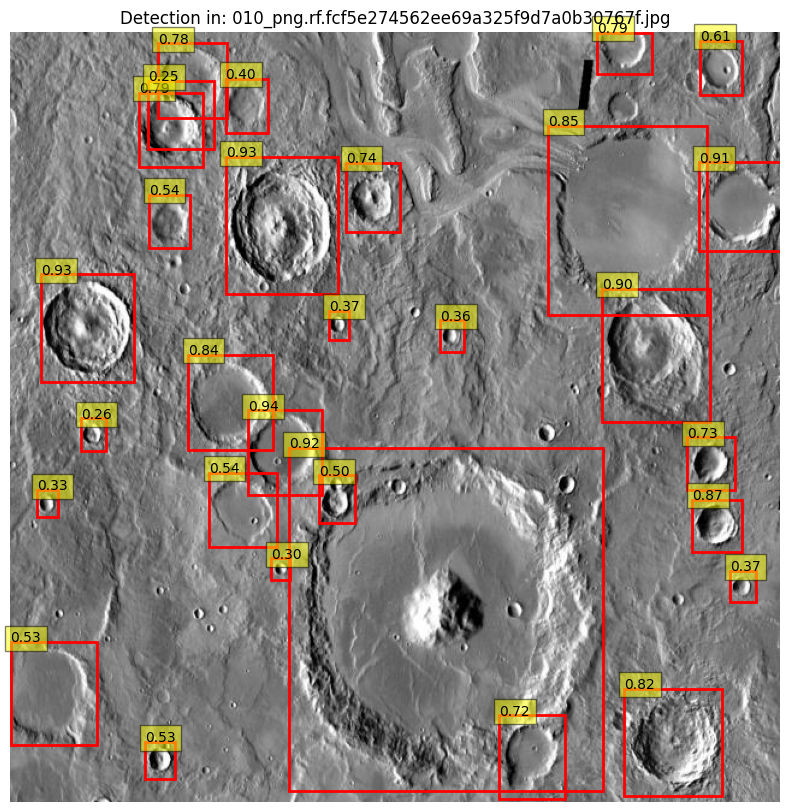


image 1/1 D:\NOTEBOOK\FYP\KaggleDataset\craters\test\images\015_png.rf.7d5b2091b6339c9480a171a59c52c3b9.jpg: 640x640 13 class_0s, 84.1ms
Speed: 3.3ms preprocess, 84.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


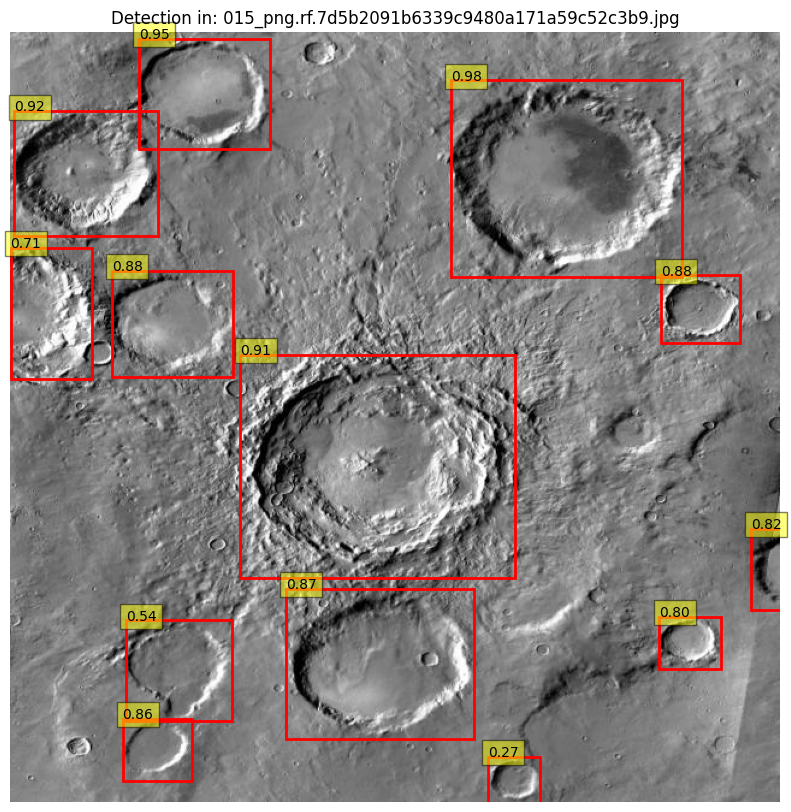


image 1/1 D:\NOTEBOOK\FYP\KaggleDataset\craters\test\images\019_png.rf.1930cd277f9bf0e3fa57f2dcfee0385f.jpg: 640x640 9 class_0s, 86.3ms
Speed: 3.9ms preprocess, 86.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


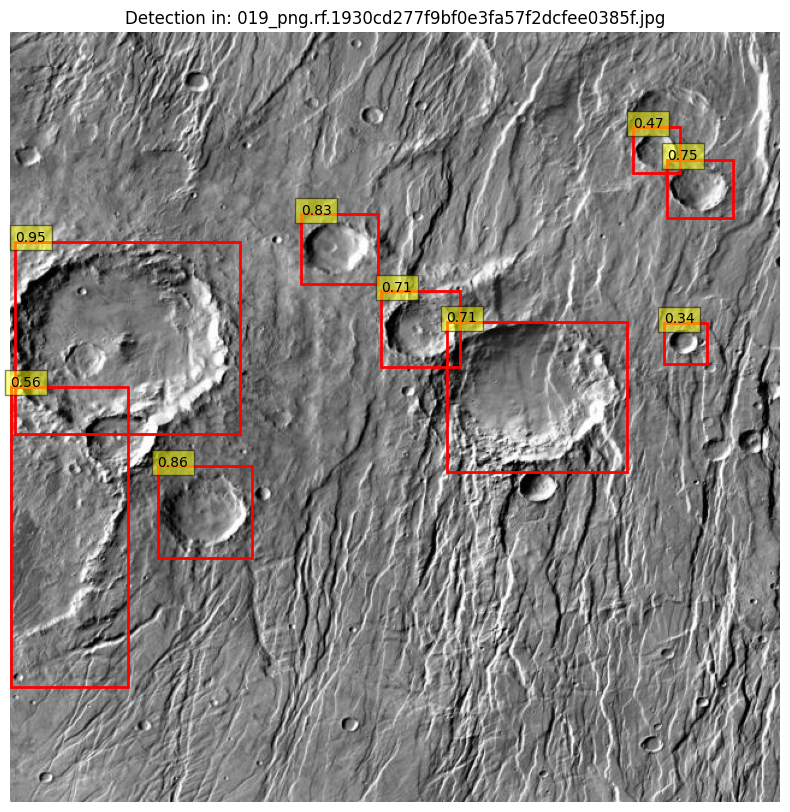


image 1/1 D:\NOTEBOOK\FYP\KaggleDataset\craters\test\images\04_png.rf.81a7d6cbeb9dc09e5a8ecd40e185fc92.jpg: 640x640 16 class_0s, 109.8ms
Speed: 3.0ms preprocess, 109.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


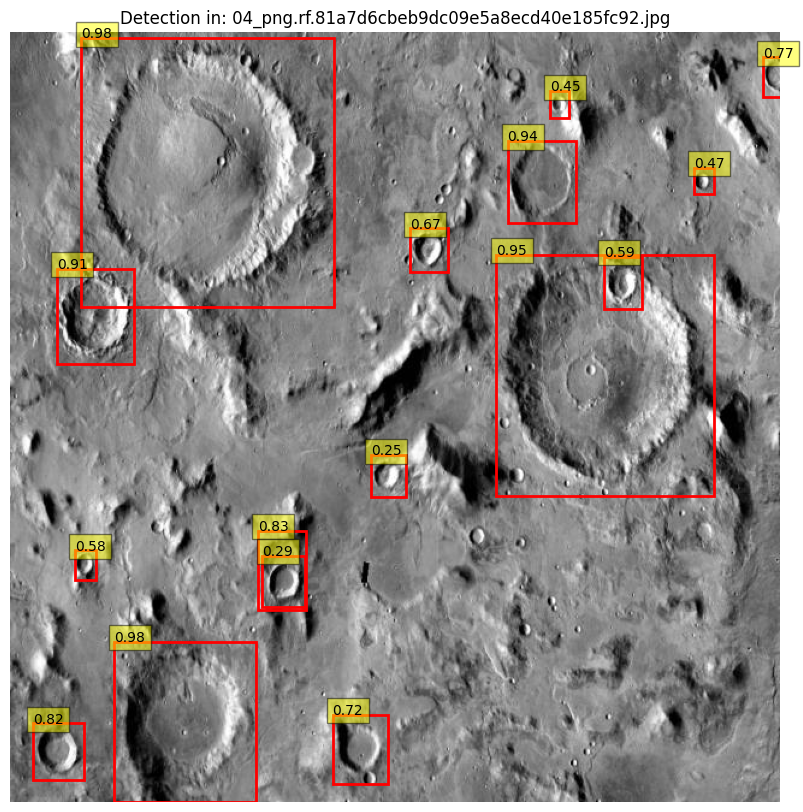


image 1/1 D:\NOTEBOOK\FYP\KaggleDataset\craters\test\images\mars_crater--100-_jpg.rf.a2ad5867efb2d73e86d9d980ca40a9fe.jpg: 640x640 6 class_0s, 188.6ms
Speed: 3.7ms preprocess, 188.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


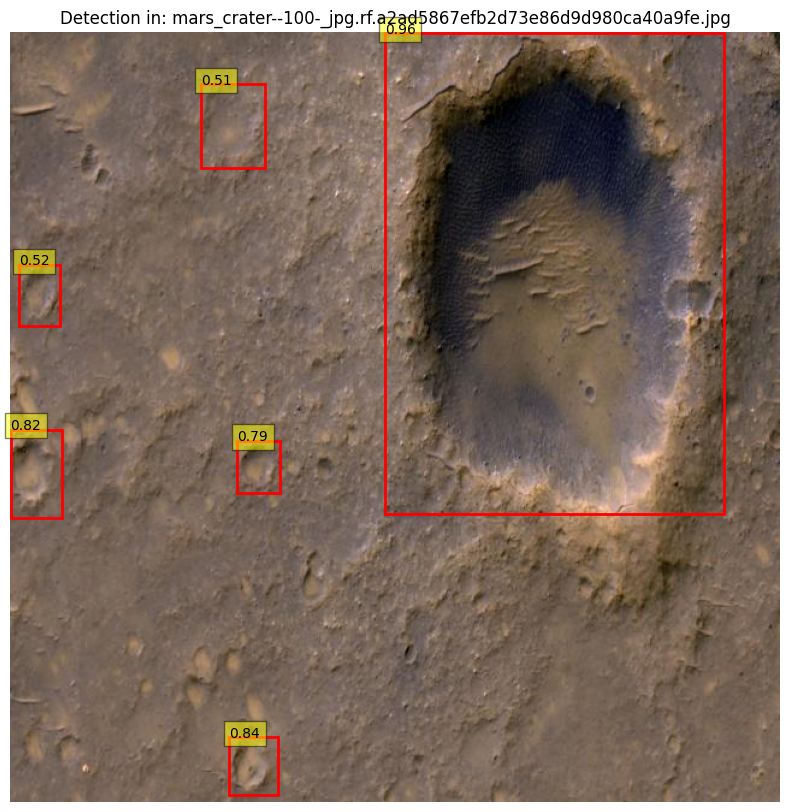


image 1/1 D:\NOTEBOOK\FYP\KaggleDataset\craters\test\images\mars_crater--108-_jpg.rf.9395f473f249e064dbfea078e2519a17.jpg: 640x640 17 class_0s, 176.5ms
Speed: 13.1ms preprocess, 176.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


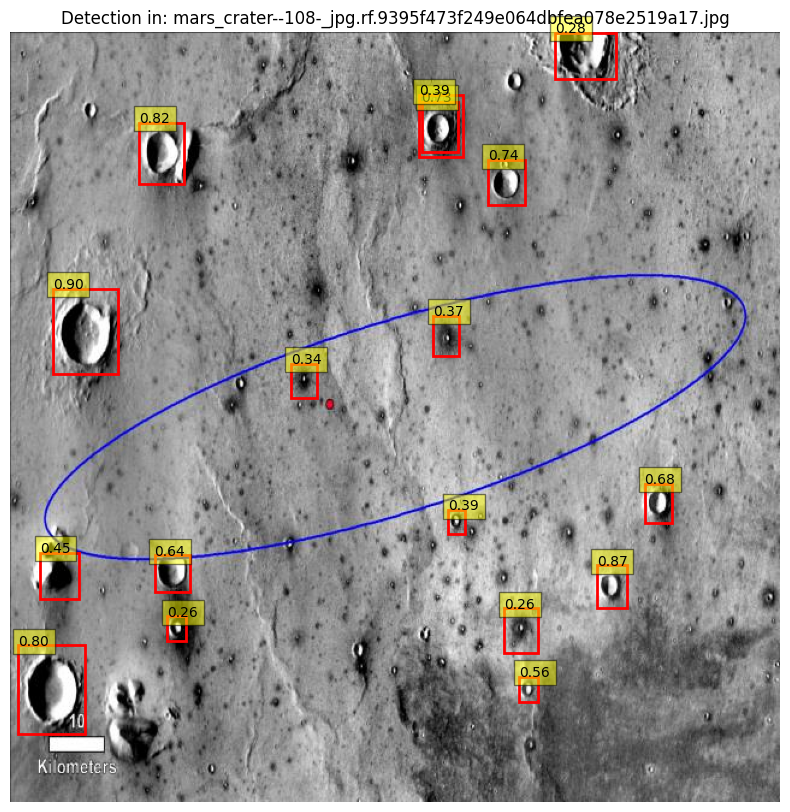


image 1/1 D:\NOTEBOOK\FYP\KaggleDataset\craters\test\images\mars_crater--116-_jpg.rf.2e550a693a8800808e68848484716b95.jpg: 640x640 9 class_0s, 121.4ms
Speed: 3.2ms preprocess, 121.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


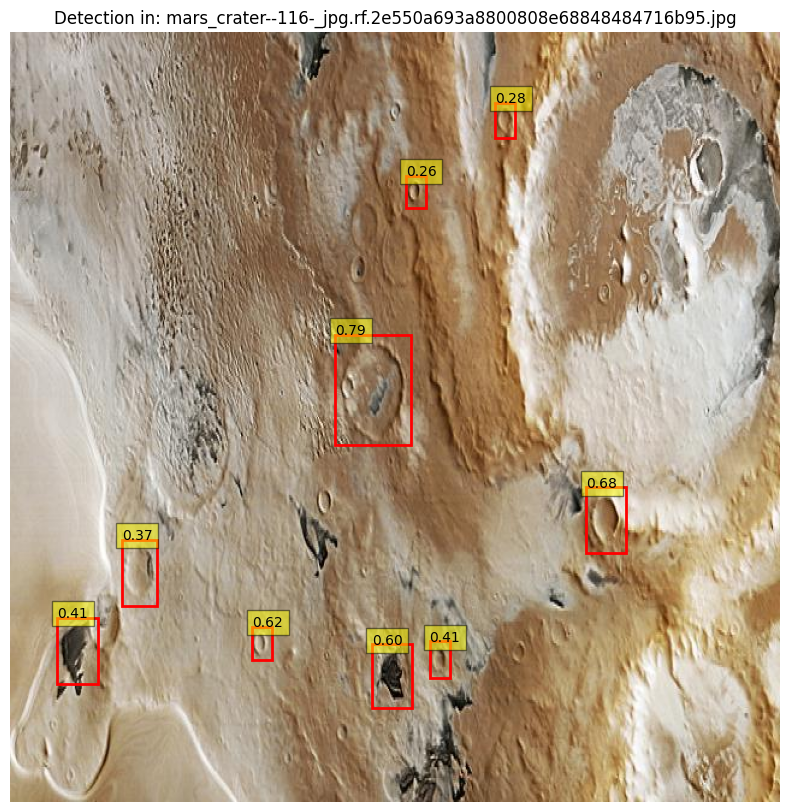


image 1/1 D:\NOTEBOOK\FYP\KaggleDataset\craters\test\images\mars_crater--117-_jpg.rf.b412b6593d102c5f9dda7bce79bb815c.jpg: 640x640 10 class_0s, 226.1ms
Speed: 5.0ms preprocess, 226.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


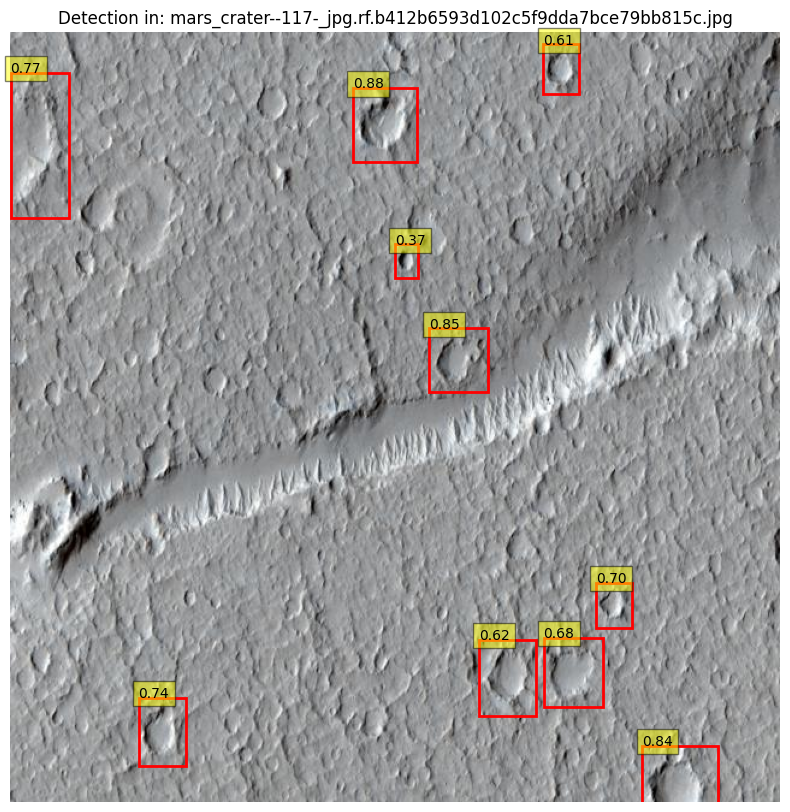


image 1/1 D:\NOTEBOOK\FYP\KaggleDataset\craters\test\images\mars_crater--12-_jpg.rf.26060e7ca4ca8781bcaf011b9b70b7db.jpg: 640x640 2 class_0s, 290.3ms
Speed: 4.4ms preprocess, 290.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


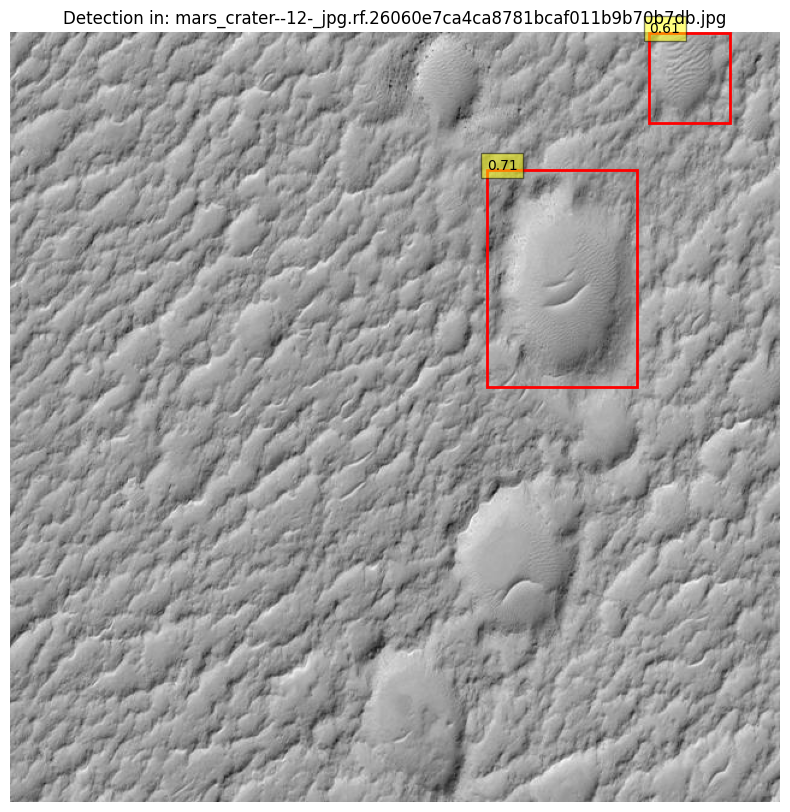


image 1/1 D:\NOTEBOOK\FYP\KaggleDataset\craters\test\images\mars_crater--25-_jpg.rf.a06bfa24b404b064ead471f56d636e0e.jpg: 640x640 3 class_0s, 201.3ms
Speed: 3.4ms preprocess, 201.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


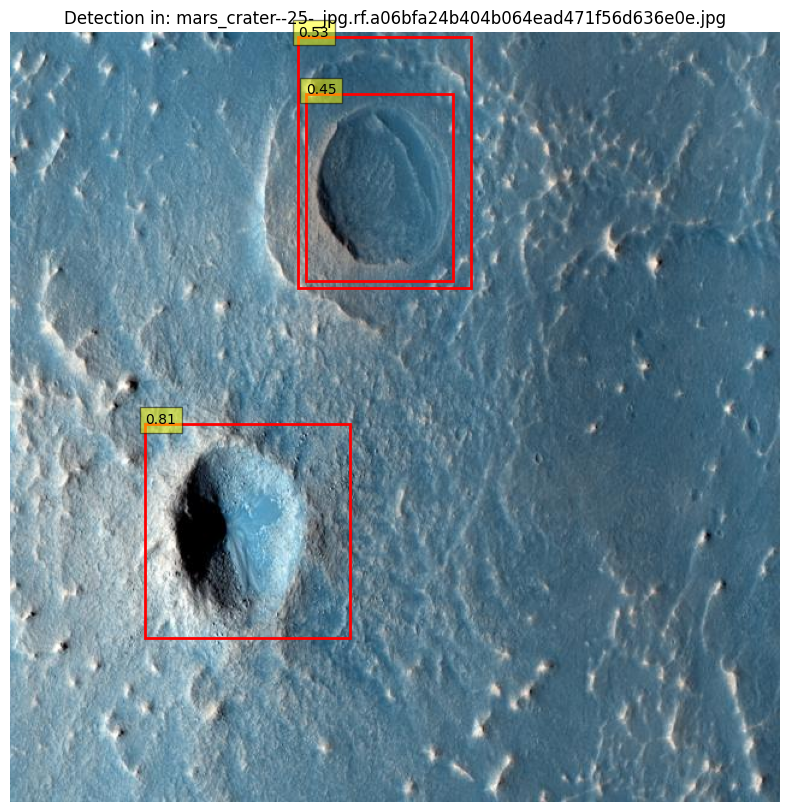

In [18]:
# Visualize sample detections
def visualize_detections(model, image_path, n_samples=10):
    image_files = os.listdir(image_path)[:n_samples]
    for img_file in image_files:
        img_path = os.path.join(image_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = model(img_path)
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(img)
        
        for result in results[0].boxes:
            x_min, y_min, x_max, y_max = result.xyxy[0].tolist()
            conf = result.conf[0].item()
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='red', facecolor='none', linewidth=2)
            ax.add_patch(rect)
            ax.text(x_min, y_min, f'{conf:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))
        
        plt.title(f'Detection in: {img_file}')
        plt.axis('off')
        plt.show()

visualize_detections(model, test_img_path)